In [1]:
# https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
# https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
# TODO: Resettare pesi ed optimizert ad ogni KFold, è il metodo giusto? Chiedere forum --- usare torch.no_grad()?
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR,OneCycleLR

import numpy as np
from sklearn.model_selection import KFold

In [10]:
import ipynb
from ipynb.fs.full.utils import fix_seed, train_one_epoch, test_one_epoch, reset_wgts, show_batch

In [3]:
SEED = 123
fix_seed(SEED)

In [4]:
IMGS_PATH = '/media/users/cgambina/Progetto_6/Dati/Immagini'

NUM_EPOCHS = 6
BS = 16 
LR = 1e-4
K = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
splits = KFold(n_splits=K, shuffle=True, random_state=SEED)

In [5]:
transforms = T.Compose([
    T.RandomChoice(
        [
            T.RandomRotation((-5,5)),
            T.RandomRotation((85,95)),
            T.RandomRotation((175,195)),
            T.RandomRotation((265,275)),
    ]),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [6]:
dataset = ImageFolder(IMGS_PATH, transforms)
criterion = nn.BCEWithLogitsLoss() 

net = resnet50(weights='ResNet50_Weights.IMAGENET1K_V1').to(device)

n_filters = net.fc.in_features
net.fc = nn.Linear(n_filters, 1).to(device) 

OPTIMIZER = optim.Adam(net.parameters(), lr=LR)  
SCHEDULER = None

In [7]:
epoch_train_loss = []; epoch_train_acc = []
epoch_test_loss = []; epoch_test_acc = []

for fold, (train_idx,test_idx) in enumerate(splits.split(dataset)):

    print(f'--- FOLD ---: {fold + 1}')
    
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    train_loader = DataLoader(dataset, batch_size=BS, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=BS, sampler=test_sampler)
    
    # Reset parametri
    net.apply(reset_wgts)
    optimizer = OPTIMIZER #TODO: è corretto resettare qui?
    scheduler = SCHEDULER

    for epoch in range(NUM_EPOCHS):
        train_loss, train_correct = train_one_epoch(net,device,train_loader,criterion,optimizer,scheduler)
        test_loss, test_correct = test_one_epoch(net,device,test_loader,criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print(f'Epoca:{epoch + 1}/{NUM_EPOCHS} AVG Training Loss:{train_loss:.3f} AVG Test Loss:{test_loss:.3f}') 
        print(f'AVG Training Acc {train_acc:.2f} % AVG Test Acc {test_acc:.2f} %')
          
    epoch_train_loss.append(train_loss); epoch_train_acc.append(train_acc)  
    epoch_test_loss.append(test_loss); epoch_test_acc.append(test_acc)

--- FOLD ---: 1
Epoca:1/6 AVG Training Loss:0.545 AVG Test Loss:1.470
AVG Training Acc 73.58 % AVG Test Acc 52.50 %
Epoca:2/6 AVG Training Loss:0.394 AVG Test Loss:0.679
AVG Training Acc 82.67 % AVG Test Acc 75.00 %
Epoca:3/6 AVG Training Loss:0.366 AVG Test Loss:0.201
AVG Training Acc 85.80 % AVG Test Acc 95.00 %
Epoca:4/6 AVG Training Loss:0.300 AVG Test Loss:0.379
AVG Training Acc 86.65 % AVG Test Acc 90.00 %
Epoca:5/6 AVG Training Loss:0.245 AVG Test Loss:0.216
AVG Training Acc 90.06 % AVG Test Acc 92.50 %
Epoca:6/6 AVG Training Loss:0.302 AVG Test Loss:0.182
AVG Training Acc 87.50 % AVG Test Acc 97.50 %
--- FOLD ---: 2
Epoca:1/6 AVG Training Loss:0.464 AVG Test Loss:1.727
AVG Training Acc 77.56 % AVG Test Acc 52.50 %
Epoca:2/6 AVG Training Loss:0.346 AVG Test Loss:0.465
AVG Training Acc 83.81 % AVG Test Acc 87.50 %
Epoca:3/6 AVG Training Loss:0.263 AVG Test Loss:0.599
AVG Training Acc 89.20 % AVG Test Acc 77.50 %
Epoca:4/6 AVG Training Loss:0.360 AVG Test Loss:0.356
AVG Training A

In [8]:
avg_train_loss = np.mean(epoch_train_loss)
avg_train_acc = np.mean(epoch_train_acc)
avg_test_loss = np.mean(epoch_test_loss)
avg_test_acc = np.mean(epoch_test_acc)

std_train_loss = np.std(epoch_train_loss)
std_train_acc = np.std(epoch_train_acc)
std_test_loss = np.std(epoch_test_loss)
std_test_acc = np.std(epoch_test_acc)

print(f'Media Training Loss: {avg_train_loss:.4f} -- Media Test Loss: {avg_test_loss:.4f}')
print(f'Media Training Accuracy: {avg_train_acc:.3f} -- Media Test Accuracy: {avg_test_acc:.3f}')

print(f'Std Training Loss: {std_train_loss:.4f} -- Std Test Loss: {std_test_loss:.4f}')
print(f'Std Training Accuracy: {std_train_acc:.3f} -- Std Test Accuracy: {std_test_acc:.3f}')

Media Training Loss: 0.2873 -- Media Test Loss: 0.2443
Media Training Accuracy: 88.180 -- Media Test Accuracy: 90.045
Std Training Loss: 0.0254 -- Std Test Loss: 0.0603
Std Training Accuracy: 1.099 -- Std Test Accuracy: 3.481


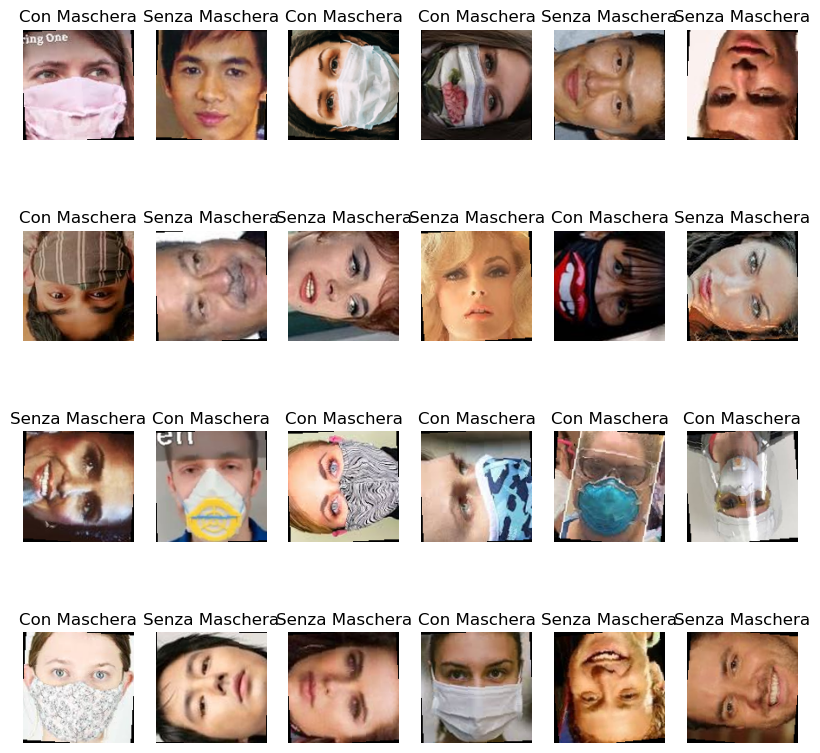

In [13]:
show_tfms = T.Compose([
    T.RandomChoice(
        [
            T.RandomRotation((-5,5)),
            T.RandomRotation((85,95)),
            T.RandomRotation((175,195)),
            T.RandomRotation((265,275)),
    ]),
    T.ToTensor(),
])

foo_dataset = ImageFolder(IMGS_PATH, show_tfms)
show_batch(foo_dataset)